# Introduction to Argo Observations

---

## Overview

If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

[add a few sentences on what the Argo program is]

Here, we introduce Argo profiling floats, which are autonomous instruments that operate remotely and sample the ocean interior continuously. 

1. What are Argo floats?
2. What data are available, and in what formats?
 
In the next notebook, [Accessing Argo Data](notebooks/argo-access.ipynb), we will explore different ways of downloading and retrieving float profiles. 


## Prerequisites (fill in)
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
# Import packages
import sys
import os
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from cmocean import cm as cmo

## What are Argo floats?

Describe what the floats do (moved by the current, take V-shaped dives)

- add image or gif showing schematic of what the floats are doing


Should show some of the ways in which Argo data is QC'd. See Tanya Maurer 2021 paper. 

- Describe what a "synthetic profile" sprof is
- Describe why we should always use "delayed-mode" data

## Argo Xarray Data Format


- Describe how the basic xarray format works (I gave example below)
- Very often, float data is packaged as an .nc file
- Show users basic ways to work around .nc files



In the next notebook, we will discuss other ways of accessing Argo data. 
Here, we will use one float as an example for what the platform is observing.

In [89]:
wmo = 5905367
flt_data = xr.open_dataset('../data/' + str(wmo) + '_Sprof.nc', decode_times=False)
flt_data

<xarray.Dataset> Size: 3MB
Dimensions:                          (N_PROF: 23, N_PARAM: 8, N_CALIB: 1,
                                      N_LEVELS: 559)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/86)
    DATA_TYPE                        object 8B ...
    FORMAT_VERSION                   object 8B ...
    HANDBOOK_VERSION                 object 8B ...
    REFERENCE_DATE_TIME              object 8B ...
    DATE_CREATION                    object 8B ...
    DATE_UPDATE                      object 8B ...
    ...                               ...
    NITRATE                          (N_PROF, N_LEVELS) float32 51kB ...
    NITRATE_QC                       (N_PROF, N_LEVELS) object 103kB ...
    NITRATE_dPRES                    (N_PROF, N_LEVELS) float32 51kB ...
    NITRATE_ADJUSTED                 (N_PROF, N_LEVELS) float32 51kB ...
    NITRATE_ADJUSTED_QC              (N_PROF, N_LEVELS) object 103kB ...
    NITRATE_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 51kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2022-07-09T21:43:13Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.13 (version 09.06.2022 for ARGO_simplified_profile)

### add description of the "attributes" in the xarray file

- all this info is online through Argo

- Try plotting temperature

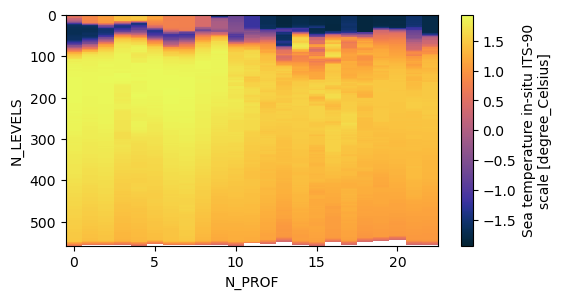

In [67]:
fig = flt_data.TEMP.T.plot(figsize = (6,3), cmap = cmo.thermal)
ax = plt.gca()
ax.invert_yaxis()

In [90]:
# Choose variables to use
float_df = flt_data[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
                         'DOXY_ADJUSTED','NITRATE_ADJUSTED', # , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
                        'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
                        'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC']].to_dataframe() #'BBP700_ADJUSTED_QC' #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
dtimes = pd.to_datetime(float_df.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))

def datetime2ytd(time):
    """ Return time in YTD format from datetime format.
    Sometimes easier to work with numerical date values."""
    return (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')
float_df['YEARDAY'] = datetime2ytd(dtimes)

# Make a profile ID for each profile
prof = float_df.index.get_level_values(0)
prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
float_df['PROFID'] = [str(wmo)+tag for tag in prof]


# Convert QC flags to integers
qc_keys = ['JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC',
    'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'] #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC', 'BBP700_ADJUSTED_QC']
for key in qc_keys:  #qc flags are not stored as ints so we can convert
        newlist = []
        for qc in float_df[key]:
                if str(qc)[2] == 'n': newlist.append('NaN')
                else: newlist.append(str(qc)[2])
        float_df[key] = newlist


In [91]:
float_df

JULD  LATITUDE  LONGITUDE  PRES_ADJUSTED  \
N_PROF N_LEVELS                                                     
0      0         24833.537697   -63.024     69.947       2.730000   
       1         24833.537697   -63.024     69.947       4.330000   
       2         24833.537697   -63.024     69.947       6.330000   
       3         24833.537697   -63.024     69.947       7.340000   
       4         24833.537697   -63.024     69.947       8.330000   
...                       ...       ...        ...            ...   
22     554       25053.849977   -63.700     86.840    1699.869995   
       555       25053.849977   -63.700     86.840    1799.140015   
       556       25053.849977   -63.700     86.840    1898.789917   
       557       25053.849977   -63.700     86.840    1999.640015   
       558       25053.849977   -63.700     86.840            NaN   

                 TEMP_ADJUSTED  PSAL_ADJUSTED  DOXY_ADJUSTED  \
N_PROF N_LEVELS                                                
0      0              0.536000      33.638802            NaN   
       1              0.538000      33.638798            NaN   
       2              0.543000      33.637810            NaN   
       3              0.541485      33.637814     360.092163   
       4              0.540000      33.637814            NaN   
...                        ...            ...            ...   
22     554            0.500300      34.686153     206.296509   
       555            0.439100      34.683056     207.902771   
       556            0.380500      34.679558     209.396149   
       557            0.343800      34.676960     210.701538   
       558                 NaN            NaN            NaN   

                 NITRATE_ADJUSTED JULD_QC POSITION_QC PRES_ADJUSTED_QC  \
N_PROF N_LEVELS                                                          
0      0                      NaN       1           1                1   
       1                      NaN       1           1                1   
       2                      NaN       1           1                1   
       3                23.776834       1           1                1   
       4                      NaN       1           1                1   
...                           ...     ...         ...              ...   
22     554              32.713676       1           1                1   
       555              32.774677       1           1                1   
       556              32.887283       1           1                1   
       557              32.685017       1           1                1   
       558                    NaN       1           1              NaN   

                TEMP_ADJUSTED_QC PSAL_ADJUSTED_QC DOXY_ADJUSTED_QC  \
N_PROF N_LEVELS                                                      
0      0                       1                1              NaN   
       1                       1                1              NaN   
       2                       1                1              NaN   
       3                       8                8                1   
       4                       1                1              NaN   
...                          ...              ...              ...   
22     554                     1                1                1   
       555                     1                1                1   
       556                     1                1                1   
       557                     1                1                1   
       558                   NaN              NaN              NaN   

                NITRATE_ADJUSTED_QC     YEARDAY      PROFID  
N_PROF N_LEVELS                                              
0      0                        NaN -368.462303  5905367000  
       1                        NaN -368.462303  5905367000  
       2                        NaN -368.462303  5905367000  
       3                          1 -368.462303  5905367000  
       4                        NaN -368.462303 

In [87]:
def list_profile_DFs(df):
    """ 
    @param df: dataframe with all profiles
    @return: list of dataframes, each with a unique profile
    """
    PROFIDs = pd.unique(df.PROFID)
    profile_DFs = []
    for i in range(len(PROFIDs)):
        profile_DFs.append(df[df['PROFID']==PROFIDs[i]].copy())
    return profile_DFs


def make_diveav(df):
    """
    Make dive-averaged dataframes (per profile). 
    @param:    df: dataframe with all profiles
    """
    prof_list = list_profile_DFs(df)

    newDF = pd.DataFrame()
    newDF['PROFID'] = pd.unique(df.PROFID)
    newDF['YEARDAY'] = [np.nanmean(x.YEARDAY) for x in prof_list]
    newDF['LATITUDE'] = [x.LATITUDE.mean() for x in prof_list]
    newDF['LONGITUDE'] = [x.LONGITUDE.mean() for x in prof_list]

    return newDF



In [88]:
make_diveav(float_df)

,PROFID,YEARDAY,LATITUDE,LONGITUDE
0,5905367000,-368.462303,-63.024000,69.947000
1,5905367001,-358.437384,-63.381000,70.567000
2,5905367002,-348.440185,-63.542000,72.828000
3,5905367003,-338.322535,-64.343000,74.709000
4,5905367004,-328.311134,-63.251000,76.556000
5,5905367005,-318.253692,-63.893000,79.424000
6,5905367006,-308.196863,-63.376000,79.971000
7,5905367007,-298.172708,-63.544000,78.989000
8,5905367008,-288.131956,-64.468000,78.684000
9,5905367009,-278.095498,-64.683000,79.777000


Add plot that shows float trajectory (latitude longitude) over time

If you have experience with SSH data, overlaying the float trajectory over satellite data would be nice. 

In [ ]:
# plot with float trajectory

In [ ]:
# use float_df and try to plot some profiles of salinity over depth 

In [ ]:
# describe QC flags (documentation online) and remove bad data from float_df

---

## Below is template material from Pythia

## Your first content section

This is where you begin your first section of material, loosely tied to your objectives stated up front. Tie together your notebook as a narrative, with interspersed Markdown text, images, and more as necessary,

In [ ]:
# as well as any and all of your code cells
print("Hello world!")

### A content subsection
Divide and conquer your objectives with Markdown subsections, which will populate the helpful navbar in Jupyter Lab and here on the Jupyter Book!

In [ ]:
# some subsection code
new = "helpful information"

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!